In [137]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import heapq
from scipy.ndimage import gaussian_filter1d,binary_closing, binary_opening
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
from scipy.ndimage import uniform_filter1d
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.ndimage import label
from scipy.ndimage import grey_opening,grey_closing
from scipy.signal import butter, filtfilt   

In [138]:
def extract_laser_segments():
    """
    根据激光控制信号（s_data）提取激光照射期间及其前后 margin 倍的时间窗口。
    该函数使用的是视频信号时间戳
    
    参数：
        t_stage: 载物台时间戳数组（一维 numpy array，单位 ms）
        t_c: 相机时间戳数组（一维 numpy array，单位 ms）
        s_data: 激光控制信号的 dataframe，列0为时间戳，列1为事件类型（2：on，3：off）

    返回：
        df_whole:追踪全程数据
        df_nt:激光照射时间内数据
    """
    # s_start = s_data[s_data[1] == 2].index
    # s_stop = s_data[s_data[1] == 3].index
    # 
    # if s_stop.empty:
    #     s_s = [len(s_data[1])]
    # else:
    #     s_s = []
    #     for m in s_start:
    #         data = (s_stop >= m)
    #         s_s.append(s_stop[data == 1][0])
    # 
    #     # 截取片段
    # t_l = int(round((s_data[0][s_start[i] + 1 : s_s[i] - 1]).diff().sum(skipna=True) / (s_s[i] - s_start[i] - 2)))
    # t = s_data[0].values
    # t_frame = np.concatenate([[t[s_start[i]] - t_l *2, t[s_start[i]] - t_l], t[s_start[i]:s_s[i]]])
    # t_start = s_data[0][s_start[i]] - t_l *2
    # t_stop = s_data[0][s_s[i] - 1] + t_l
    
    # 截取激光照射段数据
    f_start = np.searchsorted(t_c, t_start) - 1
    start_index = np.where(data_keys == f_start)[0][0]
    f_stop = np.searchsorted(t_c, t_stop)
    if f_stop > data_keys[-1]:
        f_stop = np.int64(data_keys[-1])
    stop_index = np.where(data_keys == f_stop)[0][0]
    x_c = x_s[start_index:stop_index]
    y_c = y_s[start_index:stop_index]
    angle_cut = angle_m[start_index:stop_index]
    std_c = std[start_index:stop_index]
        # 绘图
    plt.figure(figsize=(20, 10)) 
    plt.scatter(x_c[0],y_c[0], c='g', marker='^', s=50, label='Start Point')
    plt.scatter(x_c[angle_cut <= 100], y_c[angle_cut <= 100], c='b', label='Angle <= 120°', s=1)
    plt.scatter(x_c[angle_cut > 100], y_c[angle_cut > 100], c='r', label='Angle > 120°', s=1)
    plt.axis('equal')
    # plt.plot(angle_cut)
    plt.show()
    
        # 显示卷曲行为的frames
    plt.figure(figsize=(20,5))
    pattern_sequence = np.zeros(len(t_c))
    pattern_sequence[circular_frames] = 1
    # plt.plot(pattern_sequence)
    # pattern_sequence = np.zeros(len(t_c))
    pattern_sequence[branching_frames] = 1
    plt.plot(pattern_sequence)
    
    pattern_sequence = np.zeros(len(t_c))
    pattern_sequence[ano_merged] = 1
    # pattern_sequence[post_f] = 1
    plt.plot(pattern_sequence)
    plt.legend()
   
       # 显示激光照射期间的行为和食物变化
    
    i_choose = np.uint32(choose_frame)
    i_choose = i_choose[(i_choose >= start_index) & (i_choose < stop_index)]
    t_f = t_c[i_choose] / 1000
    i_m = np.uint32(merged)
    i_m = i_m[(i_m >= start_index) & (i_m < stop_index)]
    t_m = t_c[i_m] / 1000
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    pattern_sequence = np.zeros(len(t_c))
    pattern_sequence[circular_frames] = 1
    # plt.scatter(t_cut, pattern_sequence[f_start:f_stop], s=1)
    plt.plot(pattern_sequence[f_start:f_stop])
    pattern_sequence = np.zeros(len(t_c))
    pattern_sequence[branching_frames] = 1
    # plt.scatter(t_cut, pattern_sequence[f_start:f_stop], s=1)
    plt.plot(pattern_sequence[f_start:f_stop])
    plt.subplot(2,1,2)
    for xv in t_m:
        plt.axvspan(xv - 0.01, xv + 0.01, color='gray', alpha=0.1)
    # plt.scatter(t_cut, std_c, s=1)
    # plt.scatter(t_cut, angle_cut > 120, s=1)
    i_index = np.searchsorted(data_keys, i_choose)
    s_c = std[i_index]
    f_c = angle_m[i_index] > 120
    plt.scatter(t_f, s_c, s=1)
    plt.scatter(t_f[f_c], s_c[f_c], s=1)
    # plt.scatter(t_f ,angle_cut[i_choose] > 120, s=1)
    print(t_f[-1])
    print(start_index,stop_index)
    

In [139]:
def process_trajectory(shelter, frate,frame_lv=0.2, frame_as=0.5,rd_criteria=2000,smooth_window=0.5,track_jump=1,):
    """
    处理单条轨迹数据，计算线速度和角速度等。
    参数:
    shelter (list of numpy.ndarray): 轨迹数据列表，每个元素是一个 numpy 数组。
    frate (float): 帧率。
    rd_criteria (float): 用于判断的阈值。
    返回:
    list of numpy.ndarray: 处理后的轨迹数据列表。
    """
    df_slide = shelter.copy()
    smooth_window=int(smooth_window*frate)
    df_slide['X'] = df_slide['X'].rolling(window=smooth_window, center=True).mean()
    df_slide['Y'] = df_slide['Y'].rolling(window=smooth_window, center=True).mean()
    # ======================================================线速度计算===========
    data_num_lv = int(frame_lv * frate/track_jump) + 1  # 处理单个线速度所需的数据数量
    half_num_lv=data_num_lv//2
    data_num_lv=half_num_lv*2
    trajectory_0 = df_slide[['X','Y','Track_Time']].values      # 提取x,y坐标和时间戳
    trajectory_1 = (trajectory_0.copy()).astype('float')                            # 转float数据类型
    x = trajectory_1[:,0]
    y = trajectory_1[:,1]
    delta_x = (x[data_num_lv:]-x[:len(x)-data_num_lv])                       # 得到减去头尾数据点的delta_x和delta_y
    delta_y = (y[data_num_lv:]-y[:len(y)-data_num_lv])
    time_step = trajectory_1[:,2]
    time_step_lv = time_step[data_num_lv:]-time_step[:len(time_step)-data_num_lv]
    velocity_bef = np.dstack((delta_x/time_step_lv,delta_y/time_step_lv))[0]      # 使用dstack函数合并x,y方向计算的速度为一个矩阵
    speed_bef = np.linalg.norm(velocity_bef, axis = 1).reshape(-1,1)        #求模，得到速率
    nan_bin_vec = np.full((half_num_lv,2),np.nan)
    nan_bin_spd = np.full((half_num_lv,1),np.nan)
    velocity = np.vstack((nan_bin_vec, velocity_bef, nan_bin_vec))                  # 速度向量
    speed = np.vstack((nan_bin_spd, speed_bef, nan_bin_spd))                        # 速率向量
    velocity_angle = np.array([acal(v) if not np.isnan(v[0]) and not np.isnan(v[1]) else np.nan for v in velocity])
    
    df_idx = df_slide[['X','Y','Track_Time']].copy()      
    df_idx['speed'] = pd.Series(speed[:,0],index = df_idx.index)                    # 将speed和velocity加入dataframe
    df_idx['x_velocity'] = pd.Series(velocity[:,0],index = df_idx.index)
    df_idx['y_velocity'] = pd.Series(velocity[:,1],index = df_idx.index)
    df_idx['speed_smoothed'] = df_idx['speed'].rolling(window=smooth_window*3, center=True, min_periods=1).mean()
    df_idx['velocity_angle'] = pd.Series(velocity_angle, index=df_idx.index)
    # ======================================================角速度计算===========
    
    data_num_as = int(frame_as * frate/track_jump) + 1  # 处理单个角速度所需的数据数量
    hafl_num_as=data_num_as//2
    data_num_as=hafl_num_as*2
    time_step_as = time_step[data_num_as:]-time_step[:len(time_step)-data_num_as]
    trajectory_0 = df_slide[['X','Y','Track_Time']].values      # 提取x,y坐标和时间戳
    trajectory_1 = (trajectory_0.copy()).astype('float')                            # 转float数据类型
    x = trajectory_1[:,0]
    y = trajectory_1[:,1]
    delta_x = (x[data_num_as:]-x[:len(x)-data_num_as])                                     # 得到减去头尾数据点的delta_x和delta_y
    delta_y = (y[data_num_as:]-y[:len(y)-data_num_as])
    time_step = trajectory_1[:,2]  
    time_step_vec = time_step[data_num_as:]-time_step[:len(time_step)-data_num_as]        # 得到减去头尾数据点的对应delta-x和delta-y的时间
    velocity_bef = np.dstack((delta_x/time_step_vec,delta_y/time_step_vec))[0]             # 使用dstack函数合并x,y方向计算的速度为一个矩阵
    speed_bef = np.linalg.norm(velocity_bef, axis = 1).reshape(-1,1)
    nan_bin_vec = np.full((hafl_num_as,2),np.nan)
    nan_bin_spd = np.full((hafl_num_as,1),np.nan)
    velocity = np.vstack((nan_bin_vec, velocity_bef, nan_bin_vec))
    speed = np.vstack((nan_bin_spd, speed_bef, nan_bin_spd))[:,0]
    time_step_vector = np.vstack((nan_bin_spd, time_step_vec.reshape(-1,1), nan_bin_spd))[:,0]
    df_speed_cal = pd.DataFrame(speed,columns = ['speed'])
    idx_vec = df_speed_cal.index                                        # 生成索引列表时先掐头去尾再取非零值
    df_washed_speed = df_speed_cal[data_num_as//2:len(idx_vec)-data_num_as//2]
    idx_nz_vec = df_washed_speed[df_washed_speed['speed']!=0].index     # 索引是相对于总长度，但是这个列表中直接去掉了头尾速度为nan的和速率为0的点的索引
    df_speed_cal['agl_velocity'] = pd.Series([np.nan]*len(idx_vec))
    

    for i in range(data_num_as//2,len(idx_nz_vec)-data_num_as//2):
        n = data_num_as//2
        agl_i = acal(velocity[idx_nz_vec[i-n]],velocity[idx_nz_vec[i+n]]) 
        time_end= time_step[idx_nz_vec[i+n]]
        time_start = time_step[idx_nz_vec[i-n]]
        delta_t_i = time_end-time_start
#         print("timestamp", time_start, time_start)
#         print('角度计算时间间隔：',delta_t_i)
        agl_vel_i = agl_i/delta_t_i

        if not np.isnan(agl_vel_i):
            df_speed_cal.loc[idx_nz_vec[i], 'agl_velocity'] = agl_vel_i
        else:
            df_speed_cal.loc[idx_nz_vec[i], 'agl_velocity'] = 0 
    # 将angular_velocity和angular_speed加入dataframe(df_idx)
    df_idx['agl_velocity'] = pd.Series(df_speed_cal['agl_velocity'].values,index = df_idx.index)
    df_idx.loc[:,'x_velocity_agl'] = velocity[:,0]
    df_idx.loc[:,'y_velocity_agl'] = velocity[:,1]
    df_idx.loc[df_idx.speed == 0, 'agl_velocity'] = 0                 # 将speed为0的点角速度设为0
    df_idx['agl_speed'] = np.abs(df_idx['agl_velocity'])
    agl_speed_sbs= df_idx['agl_speed'].abs()
    df_idx['agl_speed_smoothed'] = (
    agl_speed_sbs
    .rolling(window=smooth_window*5, center=True, min_periods=1)
    .mean()
    )
    # ======================================================状态划分===========
    df_idx['roaming'] = (df_idx['agl_speed_smoothed'] / df_idx['speed_smoothed']) < rd_criteria
    # 将布尔值转换为整数（True -> 1, False -> 0）
    df_idx['roaming'] = df_idx['roaming'].astype(int)
    
    
    
    # # 处理 NaN 值
    # shelter[:int(framesolvelv / 2), 4:6] = np.nan
    # shelter[-int(framesolvelv / 2):, 4:6] = np.nan
    # shelter[:framesolveas - 1, 6:8] = np.nan
    # shelter[-framesolveas + 2:, 6:8] = np.nan

    return df_idx

In [140]:
def acal(vec1, vec2=[1,0]):
    """
    计算两个向量之间的夹角，并根据条件调整符号。
    参数:
    vec1 (numpy.ndarray): 第一个向量，形状为 (2,)。
    vec2 (numpy.ndarray): 第二个向量，形状为 (2,)。
    返回:
    float: 两个向量之间的夹角（角度制），范围为 [-180, 180]。
    """         
    vec3 = np.array([1, 0])  # 参考向量
    # 计算向量之间的夹角（弧度制）
    ang1 = -np.real(np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))))
    ang2 = np.real(np.arccos(np.dot(vec1, vec3) / (np.linalg.norm(vec1) * np.linalg.norm(vec3))))
    ang3 = np.real(np.arccos(np.dot(vec2, vec3) / (np.linalg.norm(vec2) * np.linalg.norm(vec3))))
    # 根据条件调整夹角的符号
    if vec1[1] > 0 and vec2[1] >= 0 and ang3 < ang2:
        ang1 = -ang1
    elif vec1[1] <= 0 and vec2[1] < 0 and ang2 < ang3:
        ang1 = -ang1
    elif vec1[1] > 0 and vec2[1] < 0 and (ang2 + ang3) <= np.pi:
        ang1 = -ang1
    elif vec1[1] < 0 and vec2[1] > 0 and (ang2 + ang3) >= np.pi:
        ang1 = -ang1
    # 处理特殊情况
    if ang1 == -np.pi:
        ang1 = np.pi
    # 将弧度转换为角度
    ang1 = ang1 / np.pi * 180
    return ang1

In [141]:
def calcium_PCA(save_path,Cal_data,window_size=20):
    """
    进行钙成像结果的PCA分析及图像生成。
    :param save_path: 文件夹根目录
    :param Cal_data: Calcium_intensity

    :return: PCA结果
    """
    cov = np.cov(Cal_data)
    ev,evec = np.linalg.eig(cov)
    sort_idx=np.argsort(ev)[::-1]
    ev=ev[sort_idx]
    evec=evec[:,sort_idx]
    expr = np.sum(ev[:2])/np.sum(ev)
    xn= Cal_data.T @ evec.real
    column_names = [f"PC{i+1}" for i in range(xn.shape[1])]
    # 转为 DataFrame
    df_n = pd.DataFrame(xn, columns=column_names)
    df_n_copy=df_n.copy()
    # 平滑角速度
    # 计算移动平均值
    df_n_copy['smoothed_PC1'] = df_n_copy['PC1'].rolling(window=window_size, min_periods=1).mean()
    df_n_copy['smoothed_PC2'] = df_n_copy['PC2'].rolling(window=window_size, min_periods=1).mean()
    df_n_copy['smoothed_PC3'] = df_n_copy['PC3'].rolling(window=window_size, min_periods=1).mean()
    df_n_copy['smoothed_PC4'] = df_n_copy['PC4'].rolling(window=window_size, min_periods=1).mean()
    cols = ['smoothed_PC1','smoothed_PC2','smoothed_PC3','smoothed_PC4']
    for col in cols:
        vector = df_n_copy[col].values
        heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
        
        # 绘制热图
        fig, ax = plt.subplots(figsize=(20, 1))  # 设置热图大小
        im = ax.imshow(heatmap_data, cmap='jet', aspect='auto')  # 绘制热图
        
        # 调整 colorbar 参数
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, aspect=30, pad=0.02)
        cbar.set_label('', fontsize=20)  # 设置颜色条标签
        cbar.ax.tick_params(labelsize=20, width=5, length=5)  # 设置刻度大小和宽度
        
        # 设置标题和轴
        ax.set_xticks([])  # 隐藏x轴刻度
        ax.set_yticks([])  # 隐藏y轴刻度
        ax.set_title(col, pad=25, fontsize=14)  # 设置标题
        
        # 保存路径
        save_filename = os.path.join(save_path, f'{col}.png')  # 以 col 命名文件
        
        # 保存图像
        plt.savefig(save_filename, bbox_inches='tight', dpi=300)  # 保存为高分辨率 PNG 文件
        plt.show()
    return df_n

In [142]:
def get_reversal_points(quick_reversal_series):
    # 创建一个 DataFrame，只包含原始列，方便处理
    df = pd.DataFrame({'quick_reversal': quick_reversal_series})
    df['quick_reversal_point'] = 0

    # 差分找变化点
    diff_qr = df['quick_reversal'].diff()

    # 标记起始和结束
    df.loc[diff_qr == 1, 'quick_reversal_point'] = 1
    df.loc[diff_qr == -1, 'quick_reversal_point'] = 2

    # 特殊情况处理：开头或结尾就是 1
    if df['quick_reversal'].iloc[0] == 1:
        df.loc[df.index[0], 'quick_reversal_point'] = 1
    if df['quick_reversal'].iloc[-1] == 1:
        df.loc[df.index[-1], 'quick_reversal_point'] = 2

    return df['quick_reversal_point']

In [157]:
def plot_custom_timeseries(
    df,
    time_col,
    line_col=None,
    scatter_col=None,
    colorbar1_col=None,
    colorbar2_col=None,
    plot_line=None,
    plot_scatter=None,
    plot_colorbar1=None,
    plot_colorbar2=None,
    figsize=(20, 3),
    title=None,
    time_range=None
):
    """
    灵活绘制时间序列图，包含线图、散点图和两个底部色条，颜色条用不同列控制。
    如果对应列名不为空且存在，默认开启对应绘图，否则不开启。
    你也可以通过 plot_xxx 参数显式开启或关闭。
    
    参数:
    - df: DataFrame，包含数据
    - time_col: 时间列名（字符串）
    - line_col: 线图数据列名（可选）
    - scatter_col: 散点图数据列名（可选）
    - colorbar1_col: 第一条色条对应列（一般0/1值）（可选）
    - colorbar2_col: 第二条色条对应列（一般NaN状态）（可选）
    - plot_line: 是否绘制线图，默认根据 line_col 自动判断
    - plot_scatter: 是否绘制散点图，默认根据 scatter_col 自动判断
    - plot_colorbar1: 是否绘制第一条色条，默认根据 colorbar1_col 自动判断
    - plot_colorbar2: 是否绘制第二条色条，默认根据 colorbar2_col 自动判断
    - figsize: 图像尺寸，默认(20,5)
    - title: 图标题
    - time_range: 时间范围限制 (start, end)，默认None不限制
    
    返回:
    - fig, ax 对象
    """
    # 根据传入列名和参数决定是否绘制
    def should_plot(col_name, plot_flag):
        if plot_flag is None:
            return (col_name is not None) and (col_name in df.columns)
        return plot_flag

    if time_range is not None:
        start, end = time_range
        df = df[(df[time_col] >= start) & (df[time_col] <= end)].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=figsize)

    if should_plot(line_col, plot_line):
        ax.plot(df[time_col], df[line_col], color='b', label=line_col)

    if should_plot(scatter_col, plot_scatter):
        ax.scatter(df[time_col], df[scatter_col], color='r', s=10, label=scatter_col)

    # y轴设置
    if should_plot(line_col, plot_line) or should_plot(scatter_col, plot_scatter):
        ax.set_ylabel('Value')
        ax.tick_params(axis='y')
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', length=0, labelleft=False)

    y_min, y_max = ax.get_ylim()
    height = (y_max - y_min) * 0.2
    base_y = y_min - height * 3.5
    num_bars = 0

    if should_plot(colorbar1_col, plot_colorbar1):
        bar1_y = base_y - height * num_bars
        vals1 = df[colorbar1_col].values[np.newaxis, :]
        cmap1 = mcolors.ListedColormap(['black', 'red'])
        extent1 = [df[time_col].iloc[0], df[time_col].iloc[-1], bar1_y, bar1_y + height]
        ax.imshow(vals1, aspect='auto', cmap=cmap1, extent=extent1)
        num_bars += 1

    if should_plot(colorbar2_col, plot_colorbar2):
        bar2_y = base_y - height * num_bars
        nan_mask = df[colorbar2_col].isna().values
        vals2 = np.where(nan_mask, 1, 0)[np.newaxis, :]
        cmap2 = mcolors.ListedColormap(['black', 'gray'])
        extent2 = [df[time_col].iloc[0], df[time_col].iloc[-1], bar2_y, bar2_y + height]
        ax.imshow(vals2, aspect='auto', cmap=cmap2, extent=extent2)
        num_bars += 1

    if num_bars > 0:
        y_bottom = base_y - height * num_bars
        ax.set_ylim(y_bottom, y_max)

    if title:
        ax.set_title(title)

    if should_plot(line_col, plot_line) or should_plot(scatter_col, plot_scatter):
        ax.legend(loc='upper right')

    plt.tight_layout()
    return fig, ax


In [176]:
def plot_custom_timeseries(
    df,
    time_col,
    line_col=None,
    scatter_col=None,
    colorbar1_col=None,
    colorbar2_col=None,
    vertical_line_col=None,      # 新增：竖线列名
    triangle_times=None,         # 新增：三角形位置数组（单位与 time_col 一致）
    plot_line=None,
    plot_scatter=None,
    plot_colorbar1=None,
    plot_colorbar2=None,
    plot_vertical_lines=None,    # 显示竖线开关
    plot_triangles=None,         # 显示三角形开关
    figsize=(20, 3),
    title=None,
    time_range=None
):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.colors as mcolors

    def should_plot(col_name, plot_flag):
        if plot_flag is None:
            return (col_name is not None) and (col_name in df.columns)
        return plot_flag

    if time_range is not None:
        start, end = time_range
        df = df[(df[time_col] >= start) & (df[time_col] <= end)].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=figsize)

    # 主线图
    if should_plot(line_col, plot_line):
        ax.plot(df[time_col], df[line_col], color='b', label=line_col)

    # 散点图
    if should_plot(scatter_col, plot_scatter):
        ax.scatter(df[time_col], df[scatter_col], color='r', s=2, label=scatter_col)

    # 线图或散点图存在时设置y轴
    if should_plot(line_col, plot_line) or should_plot(scatter_col, plot_scatter):
        ax.set_ylabel('Value')
        ax.tick_params(axis='y')
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', length=0, labelleft=False)

    y_min, y_max = ax.get_ylim()
    height = (y_max - y_min) * 0.2
    base_y = y_min - height * 3.5
    num_bars = 0

    # 底部 colorbar1
    if should_plot(colorbar1_col, plot_colorbar1):
        bar1_y = base_y - height * num_bars
        vals1 = df[colorbar1_col].values[np.newaxis, :]
        cmap1 = mcolors.ListedColormap(['black', 'red'])
        extent1 = [df[time_col].iloc[0], df[time_col].iloc[-1], bar1_y, bar1_y + height]
        ax.imshow(vals1, aspect='auto', cmap=cmap1, extent=extent1)
        num_bars += 1

    # 底部 colorbar2（NaN灰色）
    if should_plot(colorbar2_col, plot_colorbar2):
        bar2_y = base_y - height * num_bars
        nan_mask = df[colorbar2_col].isna().values
        vals2 = np.where(nan_mask, 1, 0)[np.newaxis, :]
        cmap2 = mcolors.ListedColormap(['black', 'gray'])
        extent2 = [df[time_col].iloc[0], df[time_col].iloc[-1], bar2_y, bar2_y + height]
        ax.imshow(vals2, aspect='auto', cmap=cmap2, extent=extent2)
        num_bars += 1

    if num_bars > 0:
        y_bottom = base_y - height * num_bars
        ax.set_ylim(y_bottom, y_max)

    if should_plot(vertical_line_col, plot_vertical_lines):
        vertical_times = df[df[vertical_line_col] == 1][time_col]
        for vt in vertical_times:
            ax.axvline(x=vt, color='green', linestyle='--', linewidth=1)

    if triangle_times is not None and (plot_triangles is None or plot_triangles):
        triangle_y = y_max + (y_max - y_min) * 0.05  # 稍高于最高点
        for t in triangle_times:
            ax.plot(t, triangle_y, marker='v', color='purple', markersize=8)

        # 增加 y 轴范围以容纳三角形
        ax.set_ylim(ax.get_ylim()[0], triangle_y + (y_max - y_min) * 0.1)

    if title:
        ax.set_title(title)

    if should_plot(line_col, plot_line) or should_plot(scatter_col, plot_scatter):
        ax.legend(loc='upper right')

    plt.tight_layout()
    return fig, ax


In [158]:
folder_path = r'I:\25214\0214-002'

data_stage = pd.read_csv(folder_path + '\stage_data.txt', header = None).values #读取载物台时间戳
t_stage =  data_stage[:, 0]
f_data = np.loadtxt(folder_path + '\c1.txt', delimiter=',') # 读取相机时间戳
# t_c = f_data[f_data[:,3] == 1, 1]
# 每隔5帧取一帧（适用于老数据）
indices = np.concatenate(([0], np.arange(5, len(f_data), 5)))
t_c = f_data[indices, 1].astype(int)
try:
    s_data = pd.read_csv(folder_path + '\laser-data.txt', header=None)  #读取激光激活数据
except FileNotFoundError:
    s_data = pd.read_csv(folder_path + '\s-data.txt', header=None)

Cal_data_path = os.path.join(folder_path, 'Calcium_intensity.npy')
save_path= folder_path
Cal_data= np.load(Cal_data_path)

npz_data = np.load(folder_path + '\output-0516.npz', allow_pickle=True)
data = npz_data['arr_0'].item()
# 读取npz中的数据
"""
    t_stage:载物台移动数据，原始帧率200，降采样到40fps，提供位置信息
    t_c:追踪视频帧时间戳，帧率30，提供线虫中线，周围菌液浓度等信息  
    data_keys：基于追踪视频进行处理后的视频帧。
"""
path_summary = {key: value['path_summary'] for key, value in data.items()} # 骨架分析summary
paths = {key: value['all_paths'] for key, value in data.items()} # 骨架坐标
data_keys = list(data.keys())   # 存储的符合条件的帧数
angle_m = np.array(list({key: value['angle_m'] for key, value in data.items()}.values())) # 前进方向与身体方向角度
stddev = np.array(list({key: value['stddev'] for key, value in data.items()}.values())) # 食物环境标准差结果
closest_idx = np.array(list({key: value['closest path'] for key, value in data.items()}.values()))
circle = np.array(list({key: value['circular'] for key, value in data.items()}.values())) 
branching = np.array(list({key: value['branching'] for key, value in data.items()}.values())) 
choose = np.array(list({key: value['choose_frame'] for key, value in data.items()}.values())) 
# body_angle = np.array(list({key: value['body_angle'] for key, value in data.items()}.values()))
# 平滑食物对比度
window_size=50
def moving_average(data, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')
std = moving_average(stddev, window_size)
    # 读取视频采集数据
f_data = np.loadtxt(os.path.join(folder_path,'c1.txt'), delimiter=',')
# 每5帧采集一帧（与视频帧数对应）
indices = np.concatenate(([0], np.arange(5, len(f_data), 5)))
t_c = f_data[indices, 1].astype(int)

# 读取载物台数据
stage_data = np.loadtxt(os.path.join(folder_path,'stage_data.txt'), delimiter=',')
t_stage = stage_data[:, 0]
x_stage = -stage_data[:, 3]
y_stage = stage_data[:, 4]

# 读取咽喉数据
p_data = np.loadtxt(os.path.join(folder_path,'stage_data.txt'), delimiter=',')
t_p = p_data[:, 0]
x_p = p_data[:, 1]
y_p = p_data[:, 2]
b_index = p_data[:,3]

stage_idxs = []
for i in data_keys:
    stage_idxs.append(np.searchsorted(t_stage, t_c[i]) - 1)
stage_idxs = np.array(stage_idxs)
x_s = x_stage[stage_idxs]
y_s = y_stage[stage_idxs]

# 提取每个激光照射起始和终止时刻
s_start = s_data[s_data[1] == 2].index
s_stop = s_data[s_data[1] == 3].index
if s_stop.empty:
    s_s = [len(s_data[1])]
else:
    s_s = []
    for m in s_start:
        data_1 = (s_stop >= m)
        s_s.append(s_stop[data_1 == 1][0])

# 识别卷曲动作区域
circular_frames = np.array(data_keys)[circle == 1]
branching_frames = np.array(data_keys)[branching == 1]
merged = list(heapq.merge(circular_frames, branching_frames))
choose_frame = np.array(data_keys)[choose == 1]

# 识别面积抖动区间
# iou = np.load(os.path.join(folder_path,'iou_results.npz'))['iou']
data = np.load(os.path.join(folder_path,'iou_results.npz'))
iou = data[data.files[0]] 
ano_f = np.vstack([[1, 1], iou]) < 0.7
pre_f= np.where(ano_f[:,0] == True)[0]
post_f= np.where(ano_f[:,1] == True)[0]
ano_merged = list(heapq.merge(pre_f, post_f))
# 排除IOU异常帧
choose_frame = np.setdiff1d(choose_frame, ano_merged)
# Cal_PCA=calcium_PCA(save_path,Cal_data,20)

In [159]:

i=0
t_l = int(round((s_data[0][s_start[i] + 1 : s_s[i] - 1]).diff().sum(skipna=True) / (s_s[i] - s_start[i] - 2)))
t = s_data[0].values
t_frame = np.concatenate([[t[s_start[i]] - t_l *2, t[s_start[i]] - t_l], t[s_start[i]:s_s[i]]])
t_start = s_data[0][s_start[i]] - t_l *2
t_stop = s_data[0][s_s[i] - 1] + t_l

# 截取激光照射段数据
track_tart_index = np.searchsorted(t_stage, t_start) - 1

track_stop_index = np.searchsorted(t_stage, t_stop)


"此处为运动时间"
x_c = x_s[track_tart_index:track_stop_index]
y_c = y_s[track_tart_index:track_stop_index]

        
    
stage_file = os.path.join(folder_path, f's{i+1}.txt')
vol_file = os.path.join(folder_path, f't{i+1}.txt')

# 保存文件
np.savetxt(stage_file, data_stage[track_tart_index:track_stop_index, [0,3,4]] / 1000, fmt='%.4f')  # 存储载物台数据
np.savetxt(vol_file, t_frame / 1000, fmt='%.4f')  # 存储荧光每一个volume的数据
df_pos = pd.DataFrame(data_stage[:,[0,3,4]] / 1000, 
             columns=['Track_Time', 'X', 'Y']) #追踪数据
# extract_laser_segments()
"以下计算图像时间"

data1 = t_c > t_start
id_start = np.where(data1 == 1)[0][0] - 1
if t_stop > t_c[-1]:
    id_stop = len(t_c)
else :
    data1 = t_c > t_stop
    id_stop = np.where(data1 == 1)[0][0]
f_data = np.stack((list(range(id_start, id_stop)), t_c[id_start:id_stop] / 1000),axis=1)
np.savetxt(os.path.join(folder_path, f'f{i+1}.txt'), f_data, fmt='%.4f') # 存储视频帧时间戳

# 截取激光照射段数据
f_start = np.searchsorted(t_c, t_start) - 1
start_index = np.where(data_keys == f_start)[0][0]
f_stop = np.searchsorted(t_c, t_stop)
if f_stop > data_keys[-1]:
    f_stop = np.int64(data_keys[-1])
stop_index = np.where(data_keys == f_stop)[0][0]

df_frame=pd.DataFrame(t_c/1000,columns=['Frame_time'])
df_frame['angle_m'] = np.nan
df_frame['std'] = np.nan
for i, idx in enumerate(data_keys):
    if idx < len(df_frame):  # 防止索引越界
        df_frame.loc[idx, 'angle_m'] = angle_m[i]
        df_frame.loc[idx, 'std'] = std[i]     #df_frame是追踪视频的结果

data_c= df_frame.loc[id_start:id_stop]
np.savetxt(os.path.join(folder_path, r'data_laser.txt') , data_c, fmt='%.4f', delimiter=',') #激光照射期间所有行为和食物变化


i_choose = np.uint32(choose_frame)
i_choose = i_choose[(i_choose >= start_index) & (i_choose < stop_index)]
i_index = np.searchsorted(data_keys, i_choose)
df_choose=df_frame.copy()
last_two_cols = df_choose.columns[-2:]
df_choose.loc[~df_choose.index.isin(choose_frame), last_two_cols] = np.nan
np.savetxt(os.path.join(folder_path, r'data_choose.txt'), df_choose, fmt='%.4f', delimiter=',') # 经过筛选后的数据
df_choose=pd.DataFrame(df_choose,columns=['Frame_time','angle_m','std'])
df_choose['Frame_time']=df_choose['Frame_time']/1000
df_choose=df_frame.copy()
last_two_cols = df_choose.columns[-2:]
df_choose.loc[~df_choose.index.isin(choose_frame), last_two_cols] = np.nan

In [160]:
df_laser = pd.DataFrame(t_frame / 1000,columns=['Vol_Time'])  #激光数据
track_times = df_pos['Track_Time'].values
#要考虑是使用最近的位置和周围浓度进行判断还是使用一个volumn之内的所有数据进行判断。
nearest_times = []
nearest_indices = []
for vol_time in df_laser['Vol_Time']:
    # 计算时间差的绝对值
    differences = np.abs(track_times - vol_time)
    # 找到最小差值的索引 
    nearest_idx = np.argmin(differences)
    # 保存最近时间值和索引
    nearest_times.append(track_times[nearest_idx])
    nearest_indices.append(nearest_idx)
# 将结果存入 DataFrame

df = df_pos.copy()
df.loc[:, 'X'] = -df['X']
Track_fps=int(np.mean(1/np.diff(df_pos.Track_Time.values)))
df_whole=process_trajectory(df,Track_fps,0.5,1)
foldername=os.path.basename(folder_path)    #提取数据名
file_name = f'{foldername}_dataframe_pos_pt{i+1}.csv'
df_whole.to_csv(os.path.join(folder_path, file_name), index=False)
roaming_prob=sum(df_whole['roaming'])/len(df_whole)
print(f'该数据线虫roaming比例为{roaming_prob*100:.2f}%')

df_whole= df_whole[['X', 'Y', 'Track_Time','speed','speed_smoothed','velocity_angle','agl_speed','agl_speed_smoothed','roaming']]


该数据线虫roaming比例为93.25%


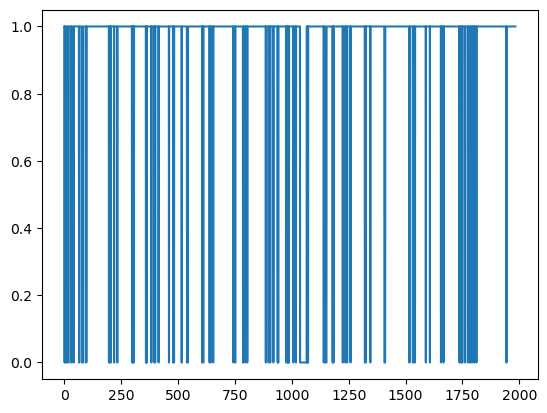

In [161]:
plt.plot(df_whole['Track_Time'], df_whole['roaming'], label='')

In [162]:
df_merged = pd.merge_asof(
    df_frame,                     # 合并到的df
    df_whole[['Track_Time','X','Y','speed','speed_smoothed','agl_speed','agl_speed_smoothed','roaming']],  # 只取需要合并的列
    left_on='Frame_time',
    right_on='Track_Time',
    direction='nearest'  
)
df_merged_choose = pd.merge_asof(
    df_choose,                     # 合并到的df
    df_whole[['Track_Time','X','Y','speed','speed_smoothed','agl_speed','agl_speed_smoothed','roaming']],  # 只取需要合并的列
    left_on='Frame_time',
    right_on='Track_Time',
    direction='nearest'  
)



df_merged_choose['reversal'] = (df_merged_choose['angle_m'] > 120).astype(int)
df_merged_choose['quick_reversal'] = ((df_merged_choose['angle_m'] > 120) & (df_merged_choose['speed_smoothed'] >0.05)).astype(int)  #为了筛掉很慢的行为（可能不是reversal）

structure = np.ones(45)
# 先进行闭操作（膨胀后腐蚀）
closed = binary_closing(df_merged_choose['quick_reversal'].astype(bool), structure=structure).astype(int)
df_merged_choose['quick_reversal_closed'] = closed

# 再进行开操作（腐蚀后膨胀）
opened = binary_opening(df_merged_choose['quick_reversal_closed'].astype(bool), structure=structure).astype(int)
df_merged_choose['quick_reversal_opened'] = opened

df_merged_choose_laser = df_merged_choose.loc[id_start:id_stop].copy()
df_merged_choose_laser['quick_reversal_point']=get_reversal_points(df_merged_choose_laser['quick_reversal'])
df_merged_choose_laser['quick_reversal_opened_point']=get_reversal_points(df_merged_choose_laser['quick_reversal_opened'])

df_nt_merged= pd.merge_asof(
    df_laser,                     # 合并到的df
    df_merged[['Track_Time','speed','speed_smoothed','agl_speed','agl_speed_smoothed','roaming','angle_m','std']],  # 只取需要合并的列
    left_on='Vol_Time',
    right_on='Track_Time',
    direction='nearest'  
)




In [163]:
print(id_start,id_stop)

1857 55732


In [170]:
track_time_array = df_merged_choose_laser['Track_Time'].to_numpy()  # 这将是 shape = (53876,)
mask = np.zeros_like(track_time_array, dtype=bool)

# 区间列表
ranges = [
    (72, 77), (91, 96), (98, 99),
    (193, 195), (198, 203), (209, 215), (218, 230), (238, 248),
    (297, 299), (301, 322), (336, 360), (379, 381), (379, 381),
    (392, 395), (399, 409), (414, 420), (477, 480), (484, 501),
    (507, 523),
    (606, 614), (641, 656), (741, 755), (767, 793), (802, 828),
    (884, 887), (895, 902), (936, 938), (973, 978), (981, 984),
    (988, 1004), (1014, 1015),
    (1065, 1067),
    (1177, 1180), (1221, 1232), (1240, 1251), (1254, 1260),
    (1318, 1320), (1342, 1350), (1406, 1416), (1420, 1422),
    (1529, 1543), (1546, 1551), (1575, 1585), (1591, 1595),
    (1604, 1613), (1652, 1662), (1734, 1753), (1770, 1788), (1796, 1807)
]
Con_dec_time= [
    89,   # 01'29
    165,  # 02'45
    296,  # 04'56
    471,  # 07'51
    580,  # 09'40
    882,  # 14'42
    889,  # 14'49
    930,  # 15'30
    1007, # 16'47
    1074, # 17'54
    1208, # 20'08
    1400, # 23'20
    1492  # 24'52
]



# 向量化判断每个时间点是否在任意一个区间内
for start, end in ranges:
    mask |= (track_time_array >= start) & (track_time_array <= end)

# 添加新列 label（和 df 行数一致）
df_merged_choose_laser['label'] = mask.astype(int)


In [187]:
df_merged_choose_laser[24500:30000]

,Frame_time,angle_m,std,Track_Time,X,Y,speed,speed_smoothed,agl_speed,agl_speed_smoothed,roaming,reversal,quick_reversal,quick_reversal_closed,quick_reversal_opened,quick_reversal_point,quick_reversal_opened_point,label
26357,880.938,18.457146,102.790231,880.944,-44.302813,22.063987,0.046281,0.045773,34.437879,35.092433,1,0,0,0,0,0,0,0
26358,880.971,15.947465,101.571910,880.964,-44.302539,22.063026,0.045603,0.045941,36.040518,35.315325,1,0,0,0,0,0,0,0
26359,881.005,16.004223,102.484463,881.006,-44.302104,22.061113,0.044589,0.046258,38.668438,35.706384,1,0,0,0,0,0,0,0
26360,881.038,12.958058,102.869109,881.046,-44.301813,22.059257,0.042803,0.046524,40.770178,36.025675,1,0,0,0,0,0,0,0
26361,881.072,9.115111,103.851203,881.066,-44.301726,22.058335,0.042577,0.046641,41.551787,36.159434,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31852,1064.567,21.626870,127.285318,1064.574,-41.220009,21.047865,0.017842,0.028338,152.017626,86.283819,0,0,0,0,0,0,0,0
31853,1064.600,38.453089,127.794386,1064.592,-41.219761,21.047478,0.017099,0.029098,151.570144,85.520793,0,0,0,0,0,0,0,0
31854,1064.633,47.144362,129.172002,1064.640,-41.219383,21.046683,0.015905,0.030646,154.768218,84.108669,0,0,0,0,0,0,0,0
31855,1064.667,69.139586,131.060606,1064.660,-41.219257,21.046278,0.015360,0.031439,156.004227,83.452515,0,0,0,0,0,0,0,0


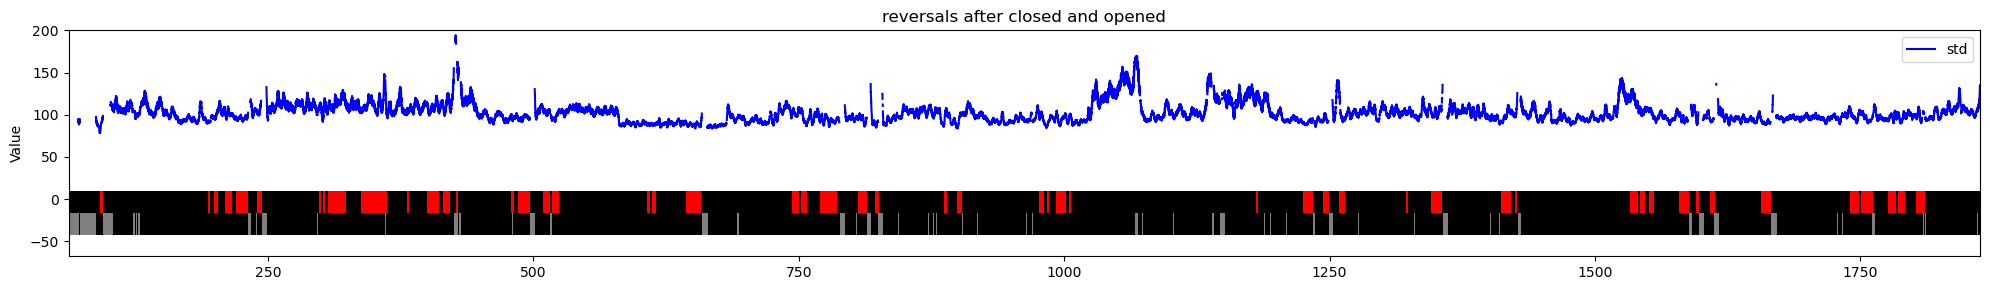

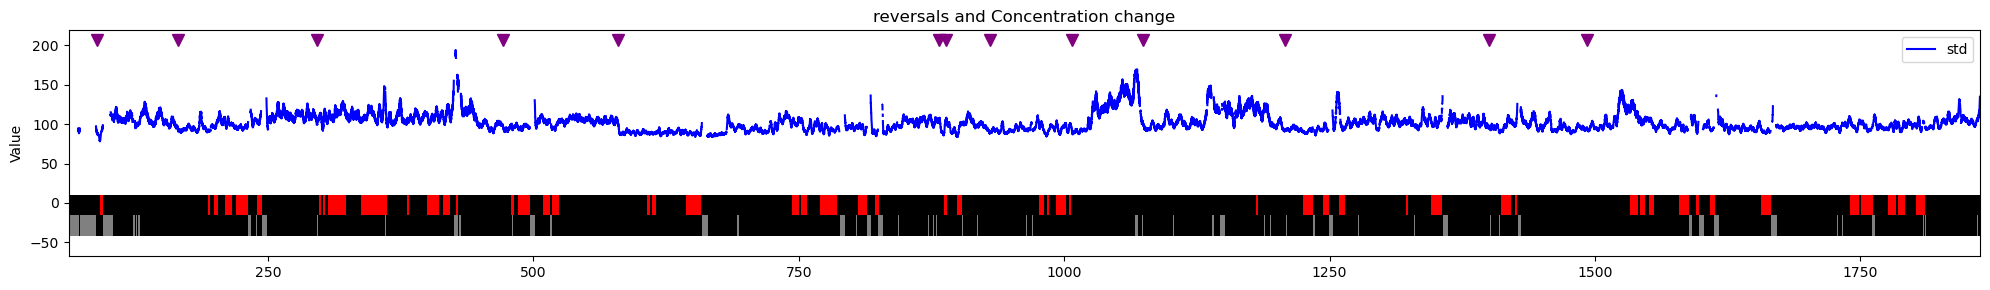

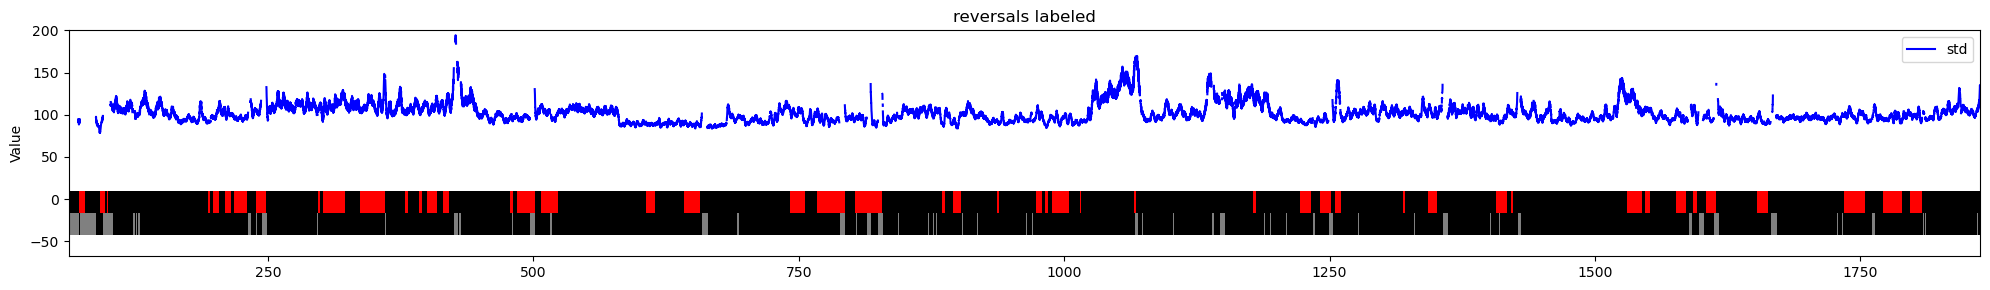

In [178]:

fig, ax = plot_custom_timeseries(
    df=df_merged_choose_laser,
    time_col='Track_Time',
    line_col='std',
    colorbar1_col='quick_reversal_opened',     # 0/1红黑条
    colorbar2_col='std',       # NaN灰黑条
    # time_range=(750,900),
    title='reversals after closed and opened'
)
plt.show()

fig, ax = plot_custom_timeseries(
    df=df_merged_choose_laser,
    time_col='Track_Time',
    line_col='std',
    # scatter_col='std',
    colorbar1_col='quick_reversal_opened',
    colorbar2_col='std',
    # vertical_line_col='Stimulus_Onset',   # Stimulus_Onset列为0或1
    triangle_times=Con_dec_time,       # 指定几个时间点画三角形
    title='reversals and Concentration change'
)
plt.show

fig, ax = plot_custom_timeseries(
    df=df_merged_choose_laser,
    time_col='Track_Time',
    line_col='std',
    colorbar1_col='label',     # 0/1红黑条
    colorbar2_col='std',       # NaN灰黑条
    # time_range=(750,900),
    title='reversals labeled'
)
plt.show()




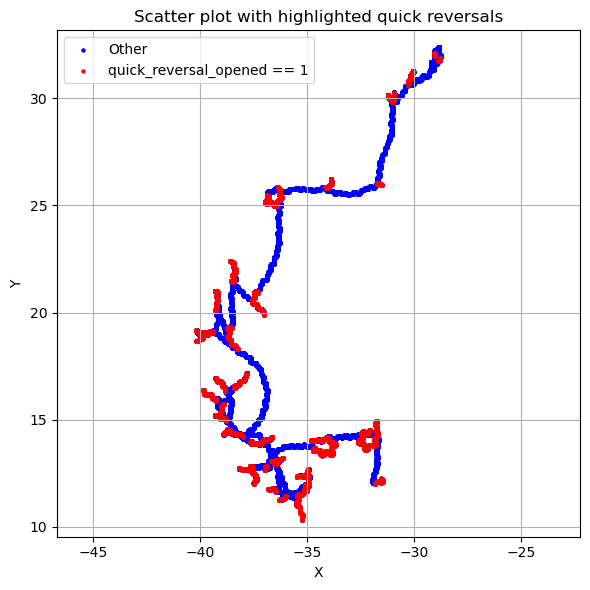

In [155]:
highlight_mask = df_merged_choose_laser['quick_reversal_opened'] == 1

# 绘图
plt.figure(figsize=(6, 6))

# 所有点：默认灰色
plt.scatter(
    df_merged_choose_laser['X'],
    df_merged_choose_laser['Y'],
    color='blue',
    s=5,
    label='Other'
)

# 高亮点：红色
plt.scatter(
    df_merged_choose_laser.loc[highlight_mask, 'X'],
    df_merged_choose_laser.loc[highlight_mask, 'Y'],
    color='red',
    s=5,
    label='quick_reversal_opened == 1'
)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot with highlighted quick reversals')
plt.legend()
plt.grid(True)
plt.axis('equal')  # 保持横纵比例一致
plt.tight_layout()
plt.show()

In [ ]:
#  #获取真实位置信息
# """
#     目前没有用到
# """
# # 载物台标校角度
# 4/ 500
# # 载物台像素标定
# l = 0.33 * 0.84  # um/pixel
# # 完成时间对齐
# t_p_t = []
# for t in t_p:
#     t_p_t.append(t_c[np.searchsorted(t_c, t) - 1])
# # 计算真实咽喉位置
# x_t = []
# y_t = []
# for t in t_p_t:
#     i = np.searchsorted(t_stage, t)
#     if i == 0:
#         t_p_t.remove(t)
#         x_p = x_p[1:]
#         y_p = y_p[1:]
#     if i == len(t_stage):
#         t_p_t.remove(t)
#         x_p = x_p[:-1]
#         y_p = y_p[:-1]
#         continue
#     t_0 = t_stage[i-1]
#     t_1 = t_stage[i]
#     x_t.append((x_stage[i] - x_stage[i-1]) / (t_1 - t_0) * (t - t_0) + x_stage[i-1]) 
#     y_t.append((y_stage[i] - y_stage[i-1]) / (t_1 - t_0) * (t - t_0) + y_stage[i-1])
# x_p_new = gaussian_filter1d(x_p, sigma = 2)
# y_p_new = gaussian_filter1d(y_p, sigma = 2)
# x_new = x_t - (x_p_new-128) * l * 4
# y_new = y_t - (y_p_new-128) * l * 4
# 
# t_p_t = np.array(t_p_t)
# stage_idxs = []
# for i in data_keys:
#     stage_idxs.append(np.searchsorted(t_p_t, t_c[i]))
# stage_idxs = np.array(stage_idxs)
# x_s = x_new[stage_idxs]
# y_s = y_new[stage_idxs]